# Data Preprocessing

This is the same as the other `preprocess_data` notebook, however, this one attempts to get rid of the stop words that may be good indicators for low-tiered star classification. Being that there is a low accuracy with classifying low-tiered stars, a custom stop-word list can be a potential solution to increasing this accuracy. This notebook produces the vectorization of the tokenized `reviewText` column that is used as input for the different modeling. The vectorization process also utilizes `Word2Vec` (which has not been used previously) and `Doc2Vec` modeling to produce the desired matrices.

## Extract data into pandas dataframe

Ensure that the `AMAZON_FASHION.json.gz` file has been downloaded and copied into this directory. See `README.md` for more information.

In [54]:
import pandas as pd
import gzip
import json

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  df = {}
  for i, d in enumerate(parse(path)):
    df[i] = d
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('../../data/raw/AMAZON_FASHION.json.gz')

In [55]:
# Remove duplicate reviews
# Any review with the same reviewText, reviewerID, overall ranking is considered a duplicate
df = df.drop_duplicates(subset=['reviewText', 'summary', 'reviewerID', 'overall'])

# Keep relevant columns
df = df[['reviewText', 'summary', 'overall']]

# Drop reviews with no reviewText or summary since we are primarily interested in analyzing review text
df = df.dropna(subset=['reviewText', 'summary'])

df.head()

,reviewText,summary,overall
0,Exactly what I needed.,perfect replacements!!,5.0
1,"I agree with the other review, the opening is ...","I agree with the other review, the opening is ...",2.0
2,Love these... I am going to order another pack...,My New 'Friends' !!,4.0
3,too tiny an opening,Two Stars,2.0
4,Okay,Three Stars,3.0


In [56]:
# Check for NaN values in each column
nan_columns = df.isna().any()
print("Columns with NaN values:")
print(nan_columns)

Columns with NaN values:
reviewText    False
summary       False
overall       False
dtype: bool


## EDA

Distribution of star ratings

Text(0, 0.5, 'Number of Reviews')

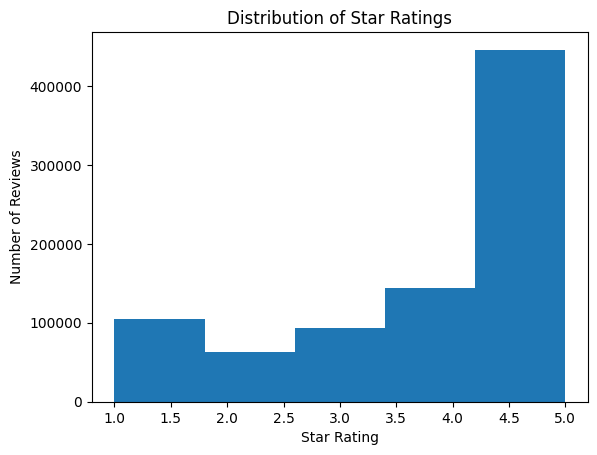

In [57]:
import matplotlib.pyplot as plt
plt.hist(df['overall'], bins=5)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')

Star ratings skew left with a clear peak for 5 stars. To avoid bias, we could consider sampling to achieve more equally distributed training data.

In [58]:
df['reviewTextLength'] = df['reviewText'].str.len()
print(df['reviewTextLength'].describe())

df['reviewSummaryLength'] = df['summary'].str.len()
print(df['reviewSummaryLength'].describe())

count    851564.000000
mean        147.731871
std         202.141667
min           1.000000
25%          36.000000
50%          88.000000
75%         180.000000
max       10565.000000
Name: reviewTextLength, dtype: float64
count    851564.000000
mean         21.645268
std          18.832864
min           1.000000
25%          10.000000
50%          12.000000
75%          28.000000
max         663.000000
Name: reviewSummaryLength, dtype: float64


reviewTextLength
1         154
2        1740
3         594
4        7749
5        4945
         ... 
6543        1
6688        1
7398        1
9461        1
10565       1
Name: count, Length: 2582, dtype: int64


(0.0, 10000.0)

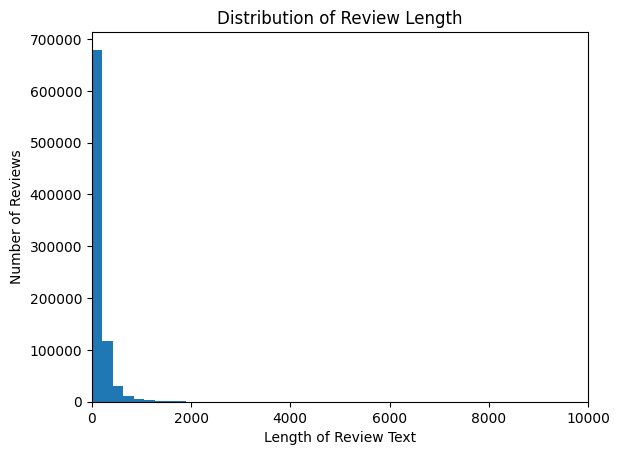

In [59]:
# look at distribution of reviewTextLength
print(df['reviewTextLength'].value_counts().sort_index())
plt.hist(df['reviewTextLength'], bins=50)
plt.title('Distribution of Review Length')
plt.xlabel('Length of Review Text')
plt.ylabel('Number of Reviews')
plt.xlim(0, 10000)

This shows that review length skews right with many large outliers.

reviewSummaryLength
1        162
2       1657
3       2053
4      10452
5       9431
       ...  
228        1
251        1
267        1
278        1
663        1
Name: count, Length: 179, dtype: int64


(0.0, 700.0)

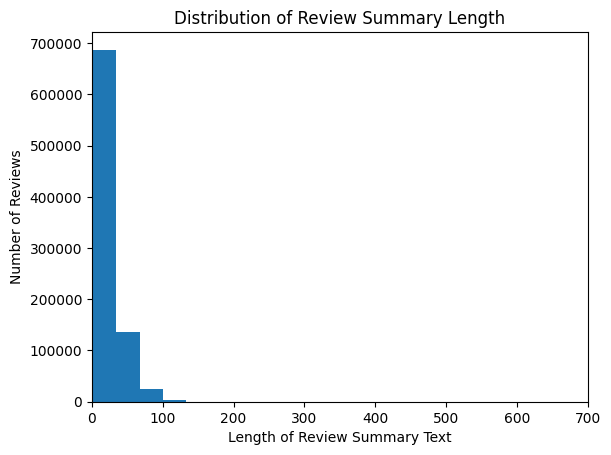

In [60]:
print(df['reviewSummaryLength'].value_counts().sort_index())
plt.hist(df['reviewSummaryLength'], bins=20)
plt.title('Distribution of Review Summary Length')
plt.xlabel('Length of Review Summary Text')
plt.ylabel('Number of Reviews')
plt.xlim(0, 700)

Summary text tends to be under 100 characters, with very few larger than that.

## Tokenization

In [61]:
# sample 50,000 reviews
df = df.sample(50000, random_state=42)

In [62]:
from nltk import word_tokenize
from collections import Counter

# Concatenate the summary and reviewText columns
df['reviewTextTotal'] = df['summary'] + ' ' + df['reviewText']

# Tokenize the reviewText column
all_words = []
for review in df['reviewTextTotal']:
    words = word_tokenize(review.lower())
    all_words.extend(words)

# Count the frequency of each word
word_counts = Counter(all_words)

# Determine the most common words
most_common_words = word_counts.most_common()


In [63]:
# Print the most common words
for word, frequency in most_common_words[:40]:
    print(f'{word}: {frequency}')

.: 101344
the: 69395
i: 64459
it: 53765
and: 48006
a: 44287
,: 43522
!: 32374
to: 29877
is: 27340
for: 23301
this: 21583
my: 19406
but: 19234
was: 16514
in: 16186
of: 16084
stars: 15791
not: 15029
very: 14336
great: 12625
on: 12024
they: 11567
love: 11446
n't: 11265
that: 11102
so: 11062
are: 10819
with: 10135
like: 10127
as: 10107
five: 9792
fit: 9494
have: 9259
's: 9148
size: 8942
you: 8831
small: 7905
them: 7813
these: 7790


In [64]:
top_40_words = [word for word, _ in most_common_words[:40]]
print(top_40_words)


['.', 'the', 'i', 'it', 'and', 'a', ',', '!', 'to', 'is', 'for', 'this', 'my', 'but', 'was', 'in', 'of', 'stars', 'not', 'very', 'great', 'on', 'they', 'love', "n't", 'that', 'so', 'are', 'with', 'like', 'as', 'five', 'fit', 'have', "'s", 'size', 'you', 'small', 'them', 'these']


In [65]:
# Words to remove that are good indicating words
words_to_remove = ['not', 'very', "n't", 'love', 'great', 'like', 'fit', 'small', 'but', 'stars', 'five', 'size', 'good']

# Filter out the words to remove
filtered_top_40_words = [word for word in top_40_words if word not in words_to_remove]

# Print the filtered list
print(filtered_top_40_words)


['.', 'the', 'i', 'it', 'and', 'a', ',', '!', 'to', 'is', 'for', 'this', 'my', 'was', 'in', 'of', 'on', 'they', 'that', 'so', 'are', 'with', 'as', 'have', "'s", 'you', 'them', 'these']


In [66]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')

stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()

# Function to tokenize, stem, and lemmatize the review text
def tokenize_stem_review(review, stopwords):
    tokens = nltk.word_tokenize(review)
    tokens = [t.lower() for t in tokens if t.lower() not in stopwords]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply tokenization, stemming, and lemmatization to each review text and using filtered top_40_words
df['reviewTokens'] = df.apply(lambda row: tokenize_stem_review(row['reviewTextTotal'], filtered_top_40_words), axis=1)

df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucym\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lucym\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,reviewText,summary,overall,reviewTextLength,reviewSummaryLength,reviewTextTotal,reviewTokens
470738,Beautiful!,Five Stars,5.0,10,10,Five Stars Beautiful!,"[five, star, beauti]"
205718,I both like and dislike this wallet. I like t...,Both like and dislike the small size.,4.0,234,37,Both like and dislike the small size. I both l...,"[both, like, dislik, small, size, both, like, ..."
524759,material really thin,One Star,1.0,20,8,One Star material really thin,"[one, star, materi, realli, thin]"
274569,Love the belt...Will not go back to a belt wit...,Love the belt,5.0,247,13,Love the belt Love the belt...Will not go back...,"[love, belt, love, belt, ..., will, not, go, b..."
374875,I chose orange color on purpose so I won't los...,Love it!!,5.0,148,9,Love it!! I chose orange color on purpose so I...,"[love, chose, orang, color, purpos, wo, n't, l..."


In [71]:
# Save the new DataFrame as CSV
new_csv_file_path = '../../data/processed/tokenized_data_sample_with_custom_stopwords.csv'

df.to_csv(new_csv_file_path)

# Confirm the CSV file has been saved
print(f"CSV file saved as '{new_csv_file_path}'")


CSV file saved as '../../data/processed/tokenized_data_sample_with_custom_stopwords.csv'


## Vectorizing Textual Features

In [72]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

tokenized_data = pd.read_csv('../../data/processed/tokenized_data_sample_with_custom_stopwords.csv')['reviewTextTotal']

# Train the Word2Vec model
vec_size = 100  # Dimensionality of the word vectors
window = 5  # Maximum distance between the current and predicted word within a sentence
min_count = 1  # Minimum frequency of a word to be considered for training
workers = 4  # Number of threads to use while training

model = Word2Vec(sentences=tokenized_data, vector_size=vec_size, window=window, min_count=min_count, workers=workers)


word_vectors = []

# Iterate through each tokenized sentence or document and retrieve word vectors
for tokens in tokenized_data:
    word_vectors.append(np.mean([model.wv[token] if token in model.wv else np.zeroes(vec_size) for token in tokens], axis=0))

# Convert the list of word vectors into a NumPy array
vectorized_features_with_custom_stopwords_word2vec = np.array(word_vectors)

In [73]:
len(vectorized_features_with_custom_stopwords_word2vec)

50000

In [75]:
import numpy as np
np.save('../../data/processed/sample_vectorized_features_with_custom_stopwords_word2vec.npy', vectorized_features_with_custom_stopwords_word2vec)


: 